- Gradient boosting is better than random forest.
- the best_params is not from the grid-search but from manual tries.
- Predicting cases:
    - cases is most important
    - adding other predictors increases accuracy
- predicting dases:
    - cases is still the most important
- early days v.s. recent days
    - accuracy is better for recent days prediction

## Use GLM to Predict Change in Cases

We are interested in using the existing cases and other information to predict the upcoming change in cases. 

We use H2O implementation to perform Linear Regression on the time series data. In this setup, we attempt to use first $n$ days of data to predict the 3-day change in the number of cases following the training period, i.e. change in case from day $n$ to day $n+3$.

The training data includes:

- Weather information
- Population
- Mobility
- Number of cases and deaths in the training period

Training data is on the county level with the first $n$ days of data averaged to create the observation by county. We found 7-day training data, i.e. $n=7$, to be the most appropriate amount of training data used for prediction the change in the number of cases in the following 3 days. 

## Predicting Early Day Cases

### Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../.')
from lib import get_data

../lib


In [38]:
df = get_data.get_model_data(date_range=(0,7), pred_day=10)
df = df._get_numeric_data().drop(['fips'],axis=1).dropna()

The get_model_data function summarizes the days of data in the date_range, and adds a column with the delta of cases until the pred_day.

In [3]:
df.shape

(545, 67)

In [4]:
X = df.drop(['day_10_delta_cases','day_10_delta_deaths'], axis = 1)
y = df.day_10_delta_cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
random_grid = {'max_depth': [1, 3, 5, None],
              'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2, 4, 8, 12],
             'n_estimators': [10, 50, 100, 200, 500]}

In [6]:
rf = RandomForestRegressor(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   45.6s finished


{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 5}

In [7]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))

Out-of-bag Accuracy: 0.6781
R-squared for Train: 0.92
R-squared for Test: 0.5858


Using randomized search for hyperparameter tuning with 3-fold cross-validation, random forest regressor with the best parameters gave us R-square of around 0.92 for taining set, and R-square of around 0.57 for testing set (it will change a bit when we re-run). The model is overfitting quite a bit on the training set, but the selected parameters narrow down the search scope for further hyperparameter tuning.

It is interesting that the best model has a low number of estimators (just 10), but no limit on the maximum depth. The best model seems to be one with a few, relatively large trees. This makes some sense for a dataset that does not have many observations, but has a large number of predictors, many of them correlated. But it could also explain why the model overfits so much.

In [8]:
param_grid = {'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],}

In [9]:
# n_estimators = 10 yields the best results
rf = RandomForestRegressor(n_estimators = 10, max_features = 'auto', max_depth = None, oob_score=True, random_state=109)
rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_gs.fit(X_train, y_train)

rf_gs.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 2}

In [10]:
rf = rf_gs.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))

y_pred = rf.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.6097
R-squared for Train: 0.91
R-squared for Test: 0.6360
Mean Absolute Error: 16.68 cases.


Next, we do a grid search for the hyperparameters using values close to those that were optimal for the random search. This grid search is done on a 3-fold cross-validation.

Now the r-squared for the testing set is a bit better, at around 0.63 (compared to 0.56 for the previous run). So we are still overfitting, but much less.
The mean absolute error for this model is around 16 cases. We'll see below how good that is, and how the error changes as a function of the total number of cases.

In [11]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.651731
14,mslPresMin,0.060055
16,mslPresMax,0.047257
18,presTendMin,0.040040
15,mslPresAvg,0.026125
61,grocery_and_pharmacy_percent_change_from_baseline,0.025442
64,pop_2018,0.022796
30,sfcPresMax,0.013855
45,windSpdMin,0.012022
1,deaths,0.011773


This is the plot of variable importance. We can see that the main variable, with 65% importance, is the number of cases. This is expected given the problem we are focusing on: the more cases we have in our population of interest, the more people are likely to get infected, so the more new infected we can expect in the next 3 days. But we can also see that the other variables overall account for about 35% of the prediction, although very divided into several. For this model, the most important predictors are for weather variables as opposed to mobility variables.

In [12]:
# predition with only cases
rf.fit(X_train.cases.values.reshape(-1,1), y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train.cases.values.reshape(-1,1), y_train))
print("R-squared for Test: %.2f" % rf.score(X_test.cases.values.reshape(-1,1), y_test))
y_pred = rf.predict(X_test.cases.values.reshape(-1,1))
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
mean_cases = round(np.mean(y_test),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')
print('Average number of cases:', mean_cases, 'cases.')

Out-of-bag Accuracy: 0.3055
R-squared for Train: 0.69
R-squared for Test: 0.35
Mean Absolute Error: 24.2 cases.
Average number of cases: 34.85 cases.


If we do our prediction using only the number of cases in the past 7 days, we can see tht our prediction accuracy drops significantly. The R-squared in the test set drops to 0.35, and the mean absolute error goes up to 24 cases. So, while the number of cases are an important predictor, the other predictors provide a very important contribution as well.

### Gradient Boosting

In [13]:
# cases
gb_hyperparameters = {
    "n_estimators": [10, 50, 100, 200, 500, 1000],
    "min_samples_split" : [2, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [1, 2, 3],
    "max_depth":[2,3,5,10]
}

#rf_random = RandomizedSearchCV(estimator = rf, 
#                               param_distributions = random_grid, 
#                               n_iter = 100, cv = 3, verbose=2, 
#                               random_state=109, n_jobs = -1)

gbr = GradientBoostingRegressor(validation_fraction = 0.3)
#gs = GridSearchCV(estimator=gbr, param_grid=gb_hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs_random = RandomizedSearchCV(estimator = gbr, 
                               param_distributions = gb_hyperparameters, 
                               n_iter = 200, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
gs_random = gs_random.fit(X_train, y_train)

gs_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.0min finished


{'n_estimators': 1000,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_depth': 2,
 'learning_rate': 0.1}

In [14]:
gbr = gs_random.best_estimator_
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.3, verbose=0, warm_start=False)

In [15]:
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
mean_cases = round(np.mean(y_test),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')
print('Average number of cases:', mean_cases, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.74
Mean Absolute Error: 17.84 cases.
Average number of cases: 34.85 cases.


In [16]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.605545
16,mslPresMax,0.074541
64,pop_2018,0.059113
15,mslPresAvg,0.054087
61,grocery_and_pharmacy_percent_change_from_baseline,0.043284
14,mslPresMin,0.035899
1,deaths,0.023969
18,presTendMin,0.015337
59,workplaces_percent_change_from_baseline,0.011430
30,sfcPresMax,0.006168


We used a similar approach for our boosted trees model, doing a random search for the best hyperparameters using 3-fold cross-validation. The final model has an R-squared in the test dataset of around 0.74, better than the random forest model.

We can also see a similar pattern as before when looking at the variable importance: the main variable in importance is the number of cases, around 0.6. This is lower than with the random forest model, suggesting that the gradient boosting model is able to extract information better from the other variables.

## Predicting Early Day Deaths

In [17]:
y = df.day_10_delta_deaths
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

In [18]:
rf = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 8, 12], "n_estimators": [10, 50, 100, 200, 500, 1000], "max_depth": [2,3,5,10]}
#gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = RandomizedSearchCV(estimator = gbr, 
                               param_distributions = param_grid, 
                               n_iter = 200, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)

gs = gs.fit(X_train, y_train)

gs.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.7min finished


{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_depth': 3}

In [19]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.2f" % rf.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
mean_cases = round(np.mean(y_test),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')
print('Average number of cases:', mean_cases, 'cases.')

R-squared for Train: 0.81
R-squared for Test: 0.48
Mean Absolute Error: 48.77 cases.
Average number of cases: 0.93 cases.


We can see that predicting deaths is much harder, with a much lower R-squared, and a huge absolute error compared to the average number of cases. This is likely because the number of deaths is very small at that point, with many counties reporting zero deaths.

In [20]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.564631
1,deaths,0.134406
16,mslPresMax,0.029837
64,pop_2018,0.028235
59,workplaces_percent_change_from_baseline,0.022060
26,relHumAvg,0.014520
63,income_2018,0.013389
52,windSpd100mAvg,0.012074
19,presTendAvg,0.011808
39,windChillMin,0.011633


## Predicting Later Day Cases

### random forest

In [21]:
df = get_data.get_model_data(date_range=(20,27), pred_day=30)
df = df._get_numeric_data().drop(['fips'],axis=1).dropna()
df.shape
# 30,37, 40 only leaves 20 rows

(215, 67)

Here we focus on predicting the number of cases on day 30th, using data from days 20 to 27. We can see that we only have 215 counties left in our dataset, because some counties have not had a large enough number of cases to have data on day 30. In other words, some counties had their 10th case less than 30 days before the end of our dataset.

In [22]:
X = df.drop(['day_30_delta_cases','day_30_delta_deaths'], axis = 1)
y = df.day_30_delta_cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
random_grid = {'max_depth': [1, 3, 5, None],
              'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2, 4, 8, 12],
             'n_estimators': [10, 50, 100, 200, 500]}

In [24]:
rf = RandomForestRegressor(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.1s finished


{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [25]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
mean_cases = round(np.mean(y_test),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')
print('Average number of cases:', mean_cases, 'cases.')

Out-of-bag Accuracy: 0.6718
R-squared for Train: 0.96
R-squared for Test: 0.7843
Mean Absolute Error: 298.77 cases.
Average number of cases: 301.26 cases.


We can see that the random forest model for the late days is more accurate than for the early days (0.73 for the late days compared to 0.67 for the early dats). This makes sense: as discussed earlier for the GLM model, the late days have a larger number of cases, which means that stochastic effects play a smaller role. In other words, the data about number of cases is less noisy for late days compared to early days.

Of course, the mean absolute error is larger, since the absolute number of cases is much larger in the late days.

In [26]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.605545
16,mslPresMax,0.074541
64,pop_2018,0.059113
15,mslPresAvg,0.054087
61,grocery_and_pharmacy_percent_change_from_baseline,0.043284
14,mslPresMin,0.035899
1,deaths,0.023969
18,presTendMin,0.015337
59,workplaces_percent_change_from_baseline,0.011430
30,sfcPresMax,0.006168


### gradient boosting

In [27]:
# cases
gb_hyperparameters = {
    "n_estimators": [10, 50, 100, 200, 500, 1000],
    "min_samples_split" : [2, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [1, 2, 3],
    "max_depth": [2,3,5,10]
}

gbr = GradientBoostingRegressor(validation_fraction = 0.3)
gs= RandomizedSearchCV(estimator = gbr, 
                               param_distributions = gb_hyperparameters, 
                               n_iter = 200, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)

gs = gs.fit(X_train, y_train)

gs.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   50.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   50.8s finished


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 2,
 'learning_rate': 0.1}

In [28]:
gbr = gs.best_estimator_
gbr.fit(X_train, y_train)
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
mean_cases = round(np.mean(y_test),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')
print('Average number of cases:', mean_cases, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.81
Mean Absolute Error: 143.51 cases.
Average number of cases: 301.26 cases.


As before, we can see that the grandient boosted model outperforms the random forest model. And also as before, we can see that the prediction for the late days is much better than for the early days, likely for the reasons mentioned earlier (larger number of cases, lower noise-to-signal).

The overall R-squared for this model in the test dataset is around 0.81.

In [29]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.794419
17,precip,0.047114
4,cldCvrMax,0.037183
26,relHumAvg,0.020789
64,pop_2018,0.018925
44,windDir100mAvg,0.015048
2,cldCvrMin,0.014367
45,windSpdMin,0.006508
27,relHumMax,0.006259
58,residential_percent_change_from_baseline,0.004166


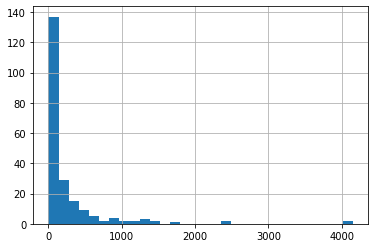

In [30]:
y.hist(bins = 30)

In [31]:
y.mean()

257.57674418604654

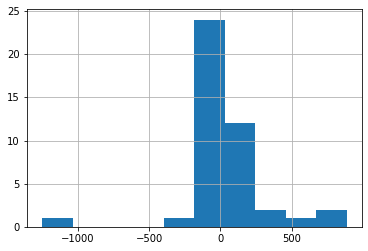

In [32]:
residuals = y_pred - y_test
residuals.hist()

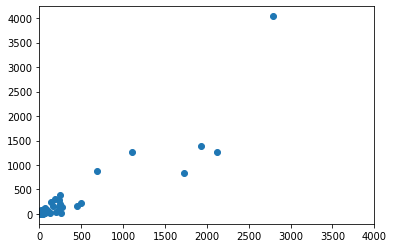

In [33]:
plt.scatter(x=y_pred, y = y_test)
#plt.yscale("log")
#plt.xscale("log")
plt.xlim([0,4000]);


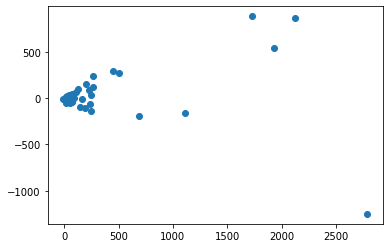

In [34]:
plt.scatter(x=y_pred, y = residuals)

## Late Day Deaths

In [35]:
y = df.day_30_delta_deaths
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
gbr = GradientBoostingRegressor(learning_rate = 0.05, min_samples_leaf = 1, min_samples_split= 5, n_estimators = 100)
gbr.fit(X_train, y_train)

print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 0.99
R-squared for Test: 0.61
Mean Absolute Error: 8.72 cases.


In [37]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.742053
1,deaths,0.082048
45,windSpdMin,0.047828
42,windDirAvg,0.027305
63,income_2018,0.012986
48,windSpd80mMin,0.011801
51,windSpd100mMin,0.009023
17,precip,0.008438
44,windDir100mAvg,0.008051
36,tempMin,0.007990
